In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ananthu017/emotion-detection-fer")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1


In [4]:
import os


# List contents of the dataset directory
print("Dataset contents:", os.listdir(path))


Dataset contents: ['train', 'test']


In [5]:
train = 'train/'
train_path = os.path.join(path, train)
print(os.listdir(train_path))
test = 'test/'
test_path = os.path.join(path, test)
print(os.listdir(test_path))

['fearful', 'surprised', 'neutral', 'sad', 'happy', 'angry']
['fearful', 'surprised', 'neutral', 'sad', 'happy', 'angry']


In [6]:
neutral_length = len(os.listdir(train_path+'neutral'))
happy_length = len(os.listdir(train_path+'happy'))
sad_length = len(os.listdir(train_path+'sad'))
surprised_length = len(os.listdir(train_path+'surprised'))
disgusted_length = len(os.listdir(train_path+'disgusted'))
fearful_length = len(os.listdir(train_path+'fearful'))
angry_length = len(os.listdir(train_path+'angry'))

print('neutral : ',neutral_length)
print('happy : ',happy_length)
print('sad : ',sad_length)
print('surprised: ',surprised_length)
print('disgusted: ',disgusted_length)
print('fearful: ',fearful_length)
print('angry: ',angry_length)


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/disgusted'

In [7]:
categories = ['neutral', 'happy', 'sad', 'surprised', 'disgusted', 'fearful', 'angry']
counts = [len(os.listdir(os.path.join(train_path, category))) for category in categories]

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'green', 'red', 'purple', 'orange', 'yellow', 'pink'])
plt.title("Data Distribution Across Emotions")
plt.xlabel("Emotion Categories")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/ananthu017/emotion-detection-fer/versions/1/train/disgusted'

In [8]:
import shutil
disgusted_path = os.path.join(train_path, 'disgusted')

# Remove the folder
if os.path.exists(disgusted_path):
    shutil.rmtree(disgusted_path)
    print("'Disgusted' class dropped successfully from train dataset.")
else:
    print("'Disgusted' folder does not exist.")

'Disgusted' folder does not exist.


In [9]:

disgusted_path = os.path.join(test_path, 'disgusted')

# Remove the folder
if os.path.exists(disgusted_path):
    shutil.rmtree(disgusted_path)
    print("'Disgusted' class dropped successfully from test dataset.")
else:
    print("'Disgusted' folder does not exist.")

'Disgusted' folder does not exist.


In [10]:
neutral_length = len(os.listdir(train_path+'neutral'))
happy_length = len(os.listdir(train_path+'happy'))
sad_length = len(os.listdir(train_path+'sad'))
surprised_length = len(os.listdir(train_path+'surprised'))
fearful_length = len(os.listdir(train_path+'fearful'))
angry_length = len(os.listdir(train_path+'angry'))

print('neutral : ',neutral_length)
print('happy : ',happy_length)
print('sad : ',sad_length)
print('surprised: ',surprised_length)
print('fearful: ',fearful_length)
print('angry: ',angry_length)

neutral :  4965
happy :  7215
sad :  4830
surprised:  3171
fearful:  4097
angry:  3995


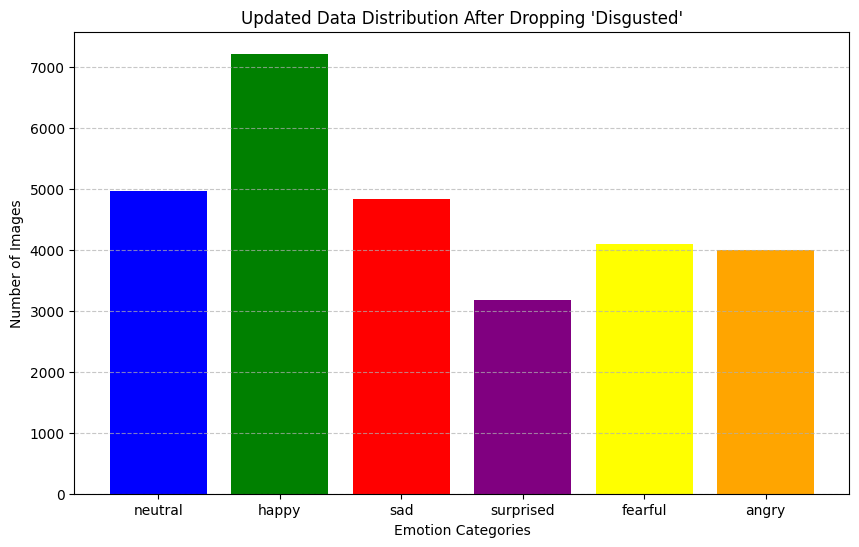

In [11]:
import matplotlib.pyplot as plt

categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']
counts = [len(os.listdir(os.path.join(train_path, category))) for category in categories]

plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['blue', 'green', 'red', 'purple', 'yellow', 'orange'])
plt.title("Updated Data Distribution After Dropping 'Disgusted'")
plt.xlabel("Emotion Categories")
plt.ylabel("Number of Images")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

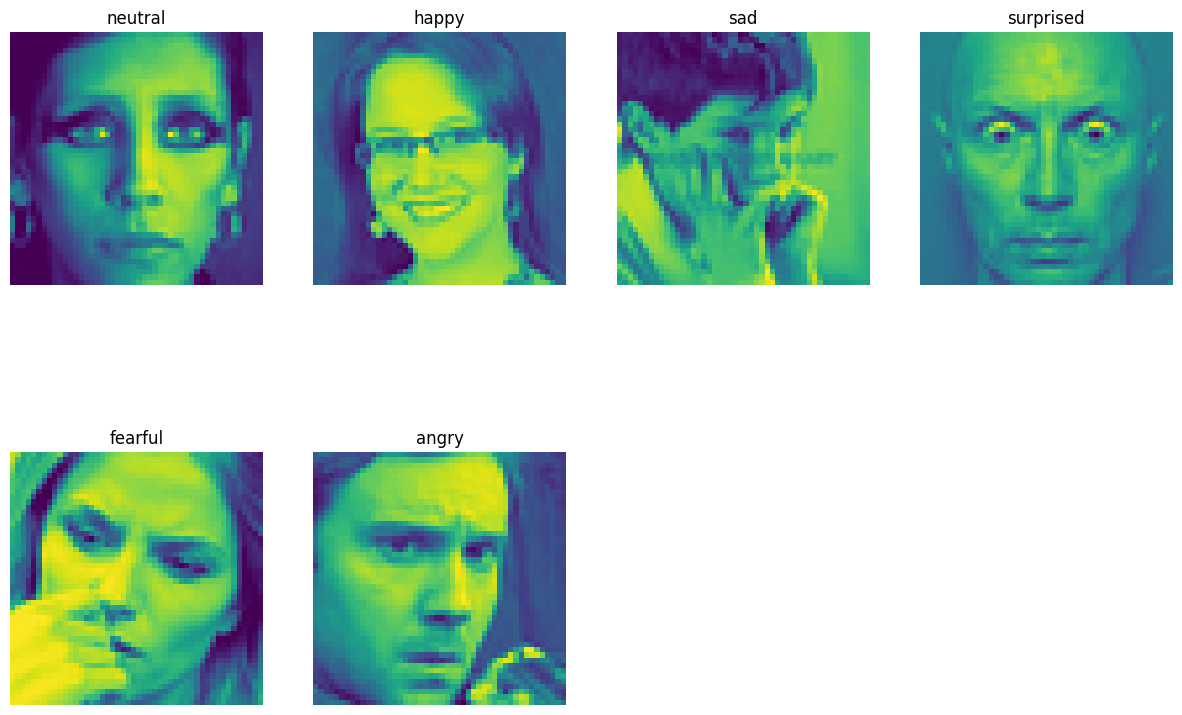

In [12]:
import matplotlib.image as imd

plt.figure(figsize=(15,10))
for i in categories:
  plt.subplot(2,4,categories.index(i)+1)
  plt.title(i)
  new_path = train_path+i+'/im0.png'
  plt.imshow(imd.imread(new_path))
  plt.axis('off')
plt.show()

In [13]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)



In [14]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class mapping
print("Class-to-Index Mapping:", train_dataset.class_to_idx)

Class-to-Index Mapping: {'angry': 0, 'fearful': 1, 'happy': 2, 'neutral': 3, 'sad': 4, 'surprised': 5}


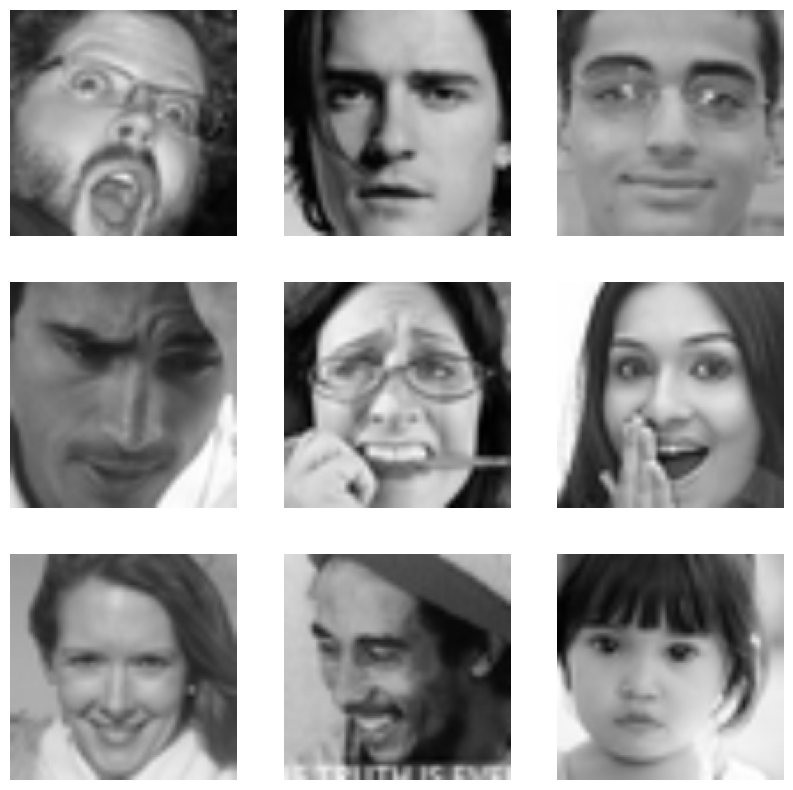

In [15]:
def show_images(loader):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show the first 9 images
        plt.subplot(3, 3, i + 1)
        img = images[i].permute(1, 2, 0)  # Rearrange dimensions to HWC for visualization
        img = img * 0.5 + 0.5  # Denormalize the image
        plt.imshow(img)
        plt.axis('off')
    plt.show()

show_images(train_loader)

In [16]:
class_weights = [sum(counts) / count for count in counts]

# Assign weights to each sample
sample_weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)


train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)  # Use sampler here
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Check the first batch of labels
for images, labels in train_loader:
    print(f"Batch size: {images.size(0)}, Labels: {labels}")
    break

Batch size: 32, Labels: tensor([4, 5, 5, 3, 2, 2, 2, 2, 4, 5, 2, 3, 5, 2, 0, 2, 4, 1, 0, 2, 3, 2, 3, 3,
        4, 1, 4, 4, 4, 0, 4, 3])


In [17]:
from collections import Counter

label_counts = Counter()
num_batches = 100  # Check the distribution over 100 batches

for _, labels in train_loader:
    label_counts.update(labels.tolist())

print("Sampled Class Distribution:", label_counts)



Sampled Class Distribution: Counter({3: 6901, 2: 6650, 4: 5187, 0: 3621, 5: 3517, 1: 2397})


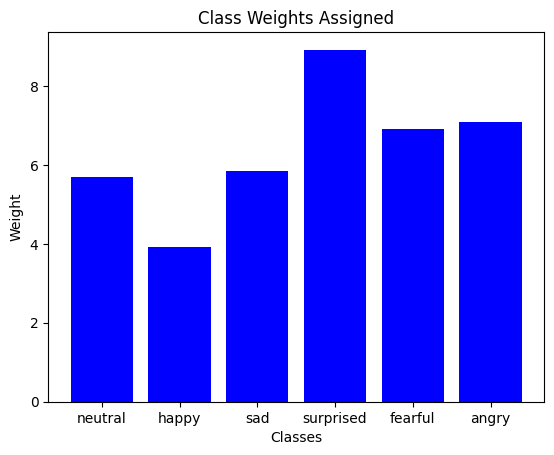

In [18]:
import matplotlib.pyplot as plt

plt.bar(categories, class_weights, color='blue')
plt.title("Class Weights Assigned")
plt.xlabel("Classes")
plt.ylabel("Weight")
plt.show()


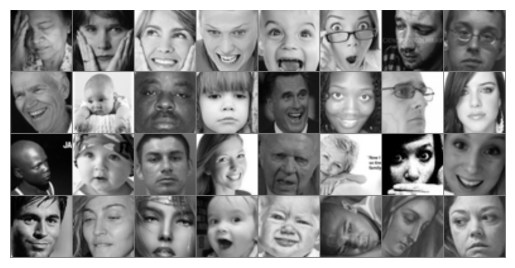

Labels:
sad sad happy angry fearful surprised sad sad happy neutral neutral fearful happy happy sad neutral sad neutral sad happy angry neutral surprised happy happy neutral sad happy angry sad sad sad


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize (if images are normalized during preprocessing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

# Get a batch of images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images in a grid
imshow(torchvision.utils.make_grid(images, nrow=8))  # nrow sets the number of images per row

# Print labels
class_names = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']  # Update as per your dataset
print('Labels:')
print(' '.join(f'{class_names[labels[j]]}' for j in range(len(labels))))


In [21]:
num_epochs = 10
batch_size = 32
l_rate = 0.01


In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define the Convolutional Neural Network
class ConvSimple(nn.Module):
    def __init__(self, input_size=(3, 128, 128), num_classes=6):
        super(ConvSimple, self).__init__()

        # Define convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input channels: 3 (RGB), Output: 32
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32, Output: 64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input: 64, Output: 128

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Reduces spatial dimensions by 2x
        self.dropout = nn.Dropout(0.5)  # Dropout for regularization
        # Dynamically calculate the flattened size
        self.flatten_size = self._get_flatten_size(input_size)

        # Define fully connected layers
        self.fc1 = nn.Linear(self.flatten_size, 128)  # First FC layer
        self.fc2 = nn.Linear(128, num_classes)        # Output layer

    def _get_flatten_size(self, input_size):
        """Calculate the size of the flattened layer dynamically."""
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_size)  # Create a dummy input tensor
            x = self.pool(F.relu(self.conv1(dummy_input)))  # Apply Conv1 + Pool
            x = self.pool(F.relu(self.conv2(x)))           # Apply Conv2 + Pool
            x = self.pool(F.relu(self.conv3(x)))           # Apply Conv3 + Pool
            return x.numel()  # Total number of elements in the output tensor

    def forward(self, x):
        """Define the forward pass."""
        # Apply convolutional layers with ReLU activations and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor for fully connected layers
        x = torch.flatten(x, 1)

        # Apply fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # Use log-softmax for classification output
        return F.log_softmax(x, dim=1)



# Instantiate the model and move it to the device
model1 = ConvSimple().to(device)

# Print model summary
summary(model1, (3, 128, 128))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model1.parameters(), lr=0.01)

# Training loop
def train_model(model, train_loader, num_epochs):
    """Train the model."""
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model1(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation loop
def evaluate_model(model, test_loader, categories):
    """Evaluate the model with additional metrics."""
    with torch.no_grad():
        model.eval()
        n_correct = 0
        n_samples = 0
        n_class_correct = [0] * len(categories)
        n_class_samples = [0] * len(categories)

        all_preds = []
        all_labels = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Collect predictions and labels for additional metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Class-wise accuracy tracking
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Print overall accuracy
        overall_acc = 100.0 * n_correct / n_samples
        print(f"Overall Accuracy: {overall_acc:.2f}%")

        # Print class-wise accuracy
        for i in range(len(categories)):
            if n_class_samples[i] > 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                print(f"Accuracy of {categories[i]}: {class_acc:.2f}%")
            else:
                print(f"Accuracy of {categories[i]}: No samples")

        # Compute Precision, Recall, F1-score
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"\nPrecision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1-score (weighted): {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("\nConfusion Matrix:")
        print(cm)

        # Detailed Classification Report (includes Precision, Recall, F1-score for each class)
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=categories))

# Example usage (update the paths and DataLoader as necessary):
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']

# Assuming train_loader and test_loader are defined
# train_loader = DataLoader(...)
# test_loader = DataLoader(...)


train_model(model1, train_loader, num_epochs)

# Evaluate the model with additional metrics
evaluate_model(model1, test_loader, categories)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
            Linear-8                    [-1, 6]             774
Total params: 4,288,454
Trainable params: 4,288,454
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.75
Params size (MB): 16.36
Estimated Total Size (MB): 25.30
----------------------------------------------------------------
Epoch 1/10, Loss: 1.8415
Epoch 2/10,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Define the Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # The shortcut (skip connection) that ensures the input is added back after convolutions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Apply two convolutions with batch normalization and ReLU, then add the shortcut connection
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the input (shortcut connection)
        out = F.relu(out)  # ReLU activation after adding the shortcut
        return out

# Define the ResNet Model
class ResNet(nn.Module):
    def __init__(self, num_classes=6, input_size=(3, 128, 128)):
        super(ResNet, self).__init__()

        # Initial Convolution layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Define Residual Blocks
        self.layer1 = self._make_layer(64, 64, stride=1, num_blocks=2)
        self.layer2 = self._make_layer(64, 128, stride=2, num_blocks=2)
        self.layer3 = self._make_layer(128, 256, stride=2, num_blocks=2)
        self.layer4 = self._make_layer(256, 512, stride=2, num_blocks=2)

        # Global Average Pooling layer
        self.gap = nn.AdaptiveAvgPool2d(1)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, stride, num_blocks):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Initial conv layer + batch normalization + ReLU
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # Apply max pooling

        # Apply residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Apply Global Average Pooling
        x = self.gap(x)

        # Flatten and apply fully connected layer
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return F.log_softmax(x, dim=1)  # LogSoftmax for multi-class classification

# Example usage:
model_conv_resnet = ResNet().to(device)

# Print model summary
summary(model_conv_resnet, (3, 128, 128))  # Input size is 128x128 RGB images

criterion = nn.CrossEntropyLoss().to(device)  # CrossEntropyLoss for multi-class classification

# Define the optimizer
optimizer = optim.Adam(model_conv_resnet.parameters(), lr=0.01)  # Adam optimizer with a learning rate of 0.01

# Training loop
def train_model(model, train_loader, num_epochs):
    """Train the model."""
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation loop with additional metrics
def evaluate_model(model, test_loader, categories):
    with torch.no_grad():
        model.eval()
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(6)]  # Corrected to 6 classes
        n_class_samples = [0 for i in range(6)]  # Corrected to 6 classes

        all_preds = []
        all_labels = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Collect predictions and labels for additional metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Class-wise accuracy tracking
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Print overall accuracy
        overall_acc = 100.0 * n_correct / n_samples
        print(f"Overall Accuracy: {overall_acc:.2f}%")

        # Print class-wise accuracy
        for i in range(len(categories)):
            if n_class_samples[i] > 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                print(f"Accuracy of {categories[i]}: {class_acc:.2f}%")
            else:
                print(f"Accuracy of {categories[i]}: No samples")

        # Compute additional metrics (Precision, Recall, F1-score)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"\nPrecision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1-score (weighted): {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("\nConfusion Matrix:")
        print(cm)

        # Detailed Classification Report (includes Precision, Recall, F1-score for each class)
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=categories))

# Categories for the dataset
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']


num_epochs = 10  # Example for 10 epochs
train_model(model_conv_resnet, train_loader, num_epochs)

# Evaluate the model with additional metrics
evaluate_model(model_conv_resnet, test_loader, categories)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,472
       BatchNorm2d-2           [-1, 64, 64, 64]             128
         MaxPool2d-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          36,928
       BatchNorm2d-7           [-1, 64, 32, 32]             128
     ResidualBlock-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,928
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,928
      BatchNorm2d-12           [-1, 64, 32, 32]             128
    ResidualBlock-13           [-1, 64, 32, 32]               0
           Conv2d-14          [-1, 128,

In [24]:
class Conv_VGG16(nn.Module):
    def __init__(self):
        super(Conv_VGG16, self).__init__()

        # Define Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)  # Batch normalization after conv1

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after conv2

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # Batch normalization after conv3

        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)  # Batch normalization after conv4

        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)  # Batch normalization after conv5

        # Define Pooling layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling with 2x2 kernel size

        # Global Average Pooling layer
        self.gap = nn.AdaptiveAvgPool2d(1)  # GAP layer to reduce dimensions

        # Define Fully Connected layers
        self.fc1 = nn.Linear(256, 512)  # Reduced from 4096 to 512 units
        self.fc2 = nn.Linear(512, 6)    # Adjusted for 6 classes
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Apply Convolutional layers with ReLU activations, Batch Normalization, and pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 + BatchNorm + Pooling
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 + BatchNorm + Pooling
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # Conv3 + BatchNorm + Pooling
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Conv4 + BatchNorm + Pooling
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # Conv5 + BatchNorm + Pooling

        # Apply Global Average Pooling to reduce spatial dimensions
        x = self.gap(x)

        # Flatten the output from GAP (single value per channel)
        x = torch.flatten(x, 1)  # Flatten for fully connected layers

        # Apply Fully Connected layers with Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Apply Dropout
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)  # LogSoftmax for multi-class classification

        return x




# Example usage:
model_conv_vgg = Conv_VGG16().to(device)

# Print model summary
summary(model_conv_vgg, (3, 128, 128))  # Input size is 48x48 RGB images

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_conv_vgg.parameters(), lr=0.01)

def train_model(model, train_loader, num_epochs):
    """Train the model."""
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print loss for the epoch
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}")

# Evaluation loop with additional metrics
def evaluate_model(model, test_loader, categories):
    with torch.no_grad():
        model.eval()
        n_correct = 0
        n_samples = 0
        n_class_correct = [0 for i in range(6)]  # Corrected to 6 classes
        n_class_samples = [0 for i in range(6)]  # Corrected to 6 classes

        all_preds = []
        all_labels = []

        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get predictions
            _, predicted = torch.max(outputs, 1)

            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

            # Collect predictions and labels for additional metrics
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Class-wise accuracy tracking
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    n_class_correct[label] += 1
                n_class_samples[label] += 1

        # Print overall accuracy
        overall_acc = 100.0 * n_correct / n_samples
        print(f"Overall Accuracy: {overall_acc:.2f}%")

        # Print class-wise accuracy
        for i in range(len(categories)):
            if n_class_samples[i] > 0:
                class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
                print(f"Accuracy of {categories[i]}: {class_acc:.2f}%")
            else:
                print(f"Accuracy of {categories[i]}: No samples")

        # Compute additional metrics (Precision, Recall, F1-score)
        precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
        recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
        f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

        print(f"\nPrecision (weighted): {precision:.4f}")
        print(f"Recall (weighted): {recall:.4f}")
        print(f"F1-score (weighted): {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print("\nConfusion Matrix:")
        print(cm)

        # Detailed Classification Report (includes Precision, Recall, F1-score for each class)
        print("\nClassification Report:")
        print(classification_report(all_labels, all_preds, target_names=categories))

# Categories for the dataset
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']


num_epochs = 10  # Example for 10 epochs
train_model(model_conv_vgg, train_loader, num_epochs)

# Evaluate the model with additional metrics
evaluate_model(model_conv_vgg, test_loader, categories)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
       BatchNorm2d-8          [-1, 128, 32, 32]             256
         MaxPool2d-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         295,168
      BatchNorm2d-14            [-1, 25

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<ipython-input-25-de1d1643c35d>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracy, palette="Blues_d")


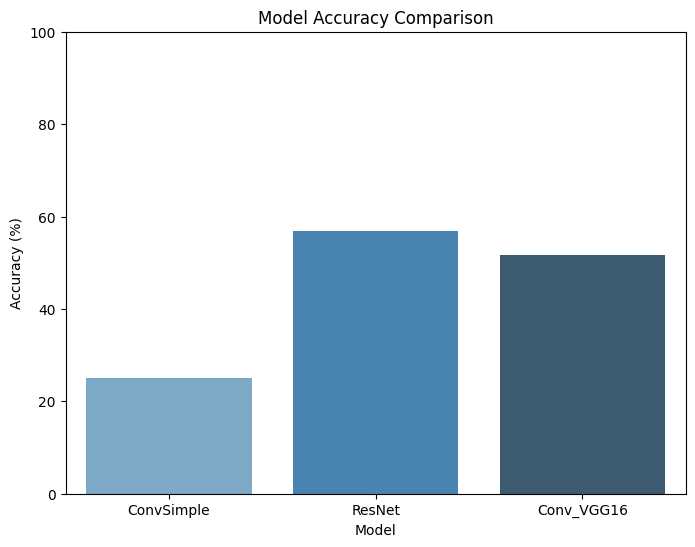

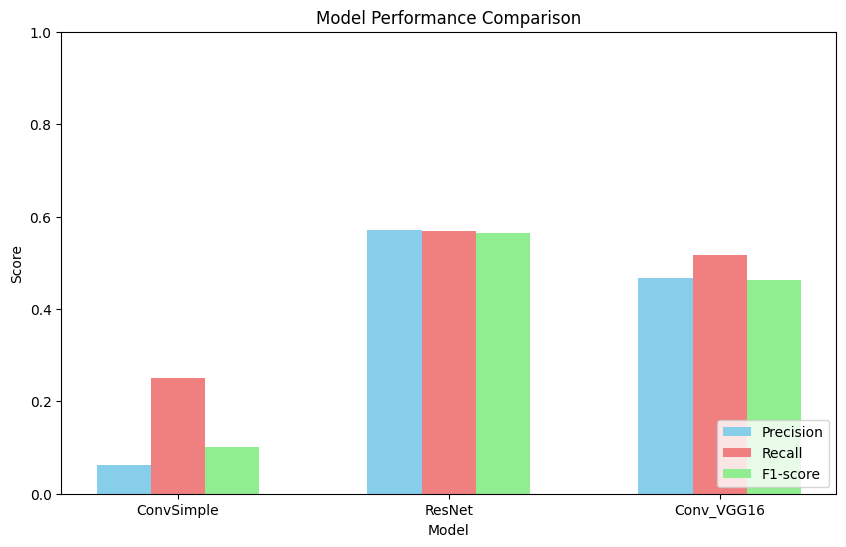

In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Model names and metrics
model_names = ['ConvSimple', 'ResNet', 'Conv_VGG16']
accuracy = [25.10, 56.91, 51.61]
precision = [0.063, 0.5716, 0.4666]
recall = [0.25, 0.5691, 0.5161]
f1_score = [0.1007, 0.5648, 0.4635]

# Create a bar plot for accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=accuracy, palette="Blues_d")
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)  # Set y-axis limits for better visualization
plt.show()

# Create a grouped bar plot for precision, recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
data = np.array([precision, recall, f1_score]).transpose()  # Transpose for grouped bars

plt.figure(figsize=(10, 6))
width = 0.2  # Width of each bar
x = np.arange(len(model_names))

plt.bar(x - width, data[:, 0], width, label='Precision', color='skyblue')
plt.bar(x, data[:, 1], width, label='Recall', color='lightcoral')
plt.bar(x + width, data[:, 2], width, label='F1-score', color='lightgreen')

plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(x, model_names)
plt.ylim(0, 1)  # Set y-axis limits for better visualization
plt.legend(loc='lower right')
plt.show()

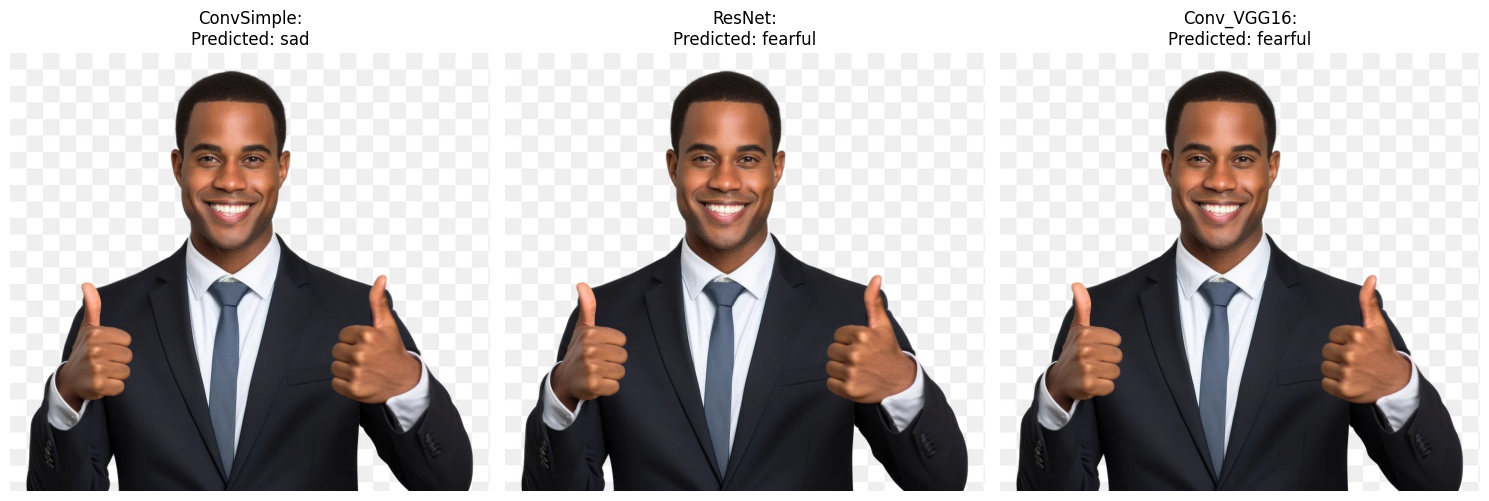

In [26]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust if different
])

# Load your own image (replace with your image path)
img_path = 'happy.jpg'  # Replace with the path to your image
img = Image.open(img_path)

# Apply the transformations to the image
img_tensor = transform(img).unsqueeze(0).to(device)

# Models to evaluate
models = [model1, model_conv_resnet, model_conv_vgg]  # Your model instances
model_names = ['ConvSimple', 'ResNet', 'Conv_VGG16']

# Define the categories
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']

# Make predictions and visualize
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))  # Create subplots

for i, model in enumerate(models):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = categories[predicted.item()]

    axes[i].imshow(img)
    axes[i].set_title(f'{model_names[i]}:\nPredicted: {predicted_class}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

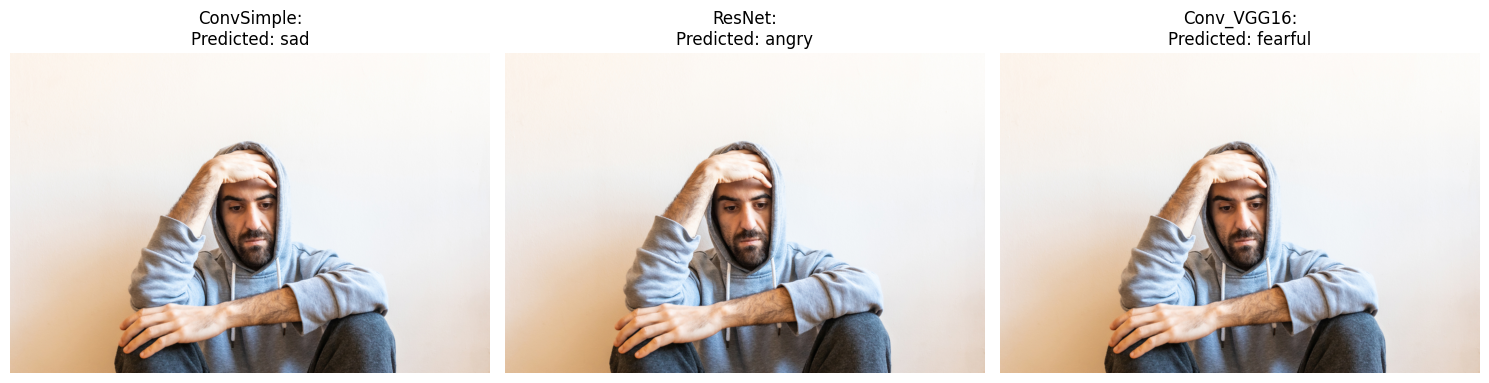

In [27]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust if different
])

# Load your own image (replace with your image path)
img_path = 'sad.jpg'  # Replace with the path to your image
img = Image.open(img_path)

# Apply the transformations to the image
img_tensor = transform(img).unsqueeze(0).to(device)

# Models to evaluate
models = [model1, model_conv_resnet, model_conv_vgg]  # Your model instances
model_names = ['ConvSimple', 'ResNet', 'Conv_VGG16']

# Define the categories
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']

# Make predictions and visualize
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))  # Create subplots

for i, model in enumerate(models):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = categories[predicted.item()]

    axes[i].imshow(img)
    axes[i].set_title(f'{model_names[i]}:\nPredicted: {predicted_class}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

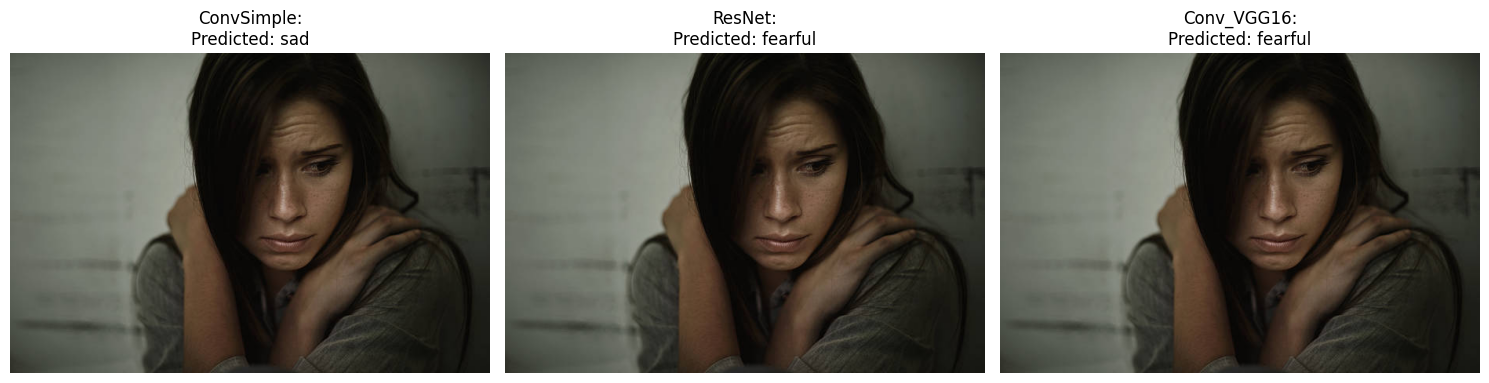

In [28]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define the transform (same as during training)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match training input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Adjust if different
])

# Load your own image (replace with your image path)
img_path = 'fearful.jpg'  # Replace with the path to your image
img = Image.open(img_path)

# Apply the transformations to the image
img_tensor = transform(img).unsqueeze(0).to(device)

# Models to evaluate
models = [model1, model_conv_resnet, model_conv_vgg]  # Your model instances
model_names = ['ConvSimple', 'ResNet', 'Conv_VGG16']

# Define the categories
categories = ['neutral', 'happy', 'sad', 'surprised', 'fearful', 'angry']

# Make predictions and visualize
fig, axes = plt.subplots(1, len(models), figsize=(15, 5))  # Create subplots

for i, model in enumerate(models):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = categories[predicted.item()]

    axes[i].imshow(img)
    axes[i].set_title(f'{model_names[i]}:\nPredicted: {predicted_class}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()